In [386]:
import os
import numpy as np 
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import joblib

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score

from scipy.stats import randint

from pandas import DataFrame


from xgboost import XGBClassifier



# The Attributess include:
- Age: age of the patient [years]
- Sex: sex of the patient 
  * M: Male 
  * F: Female
- ChestPainType: chest pain type 
  * TA: Typical Angina 
  * ATA: Atypical Angina 
  * NAP: Non-Anginal Pain 
  * ASY: Asymptomatic
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar 
  * 1: if FastingBS > 120 mg/dl 
  * 0: otherwise
- RestingECG: resting electrocardiogram results 
  * Normal: Normal 
  * ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
  * LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina 
  * Y: Yes 
  * N: No
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment 
  * Up: upsloping 
  * Flat: flat, Down: downsloping
- HeartDisease: output class 
  * 1: heart disease 
  * 0: Normal

# Exploratory Data Analysis

#### General data statistics

In [387]:
df=pd.read_csv("./data/heart.csv")

# separate label from data
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Join the train data and train labels into a full dataframe
full_train = X_train.copy()
full_train["HeartDisease"] = y
full_train = full_train.reset_index()

full_train.head()

,index,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,637,43,M,ASY,115,303,0,Normal,181,N,1.2,Flat,0
1,541,76,M,NAP,104,113,0,LVH,120,N,3.5,Down,1
2,570,56,M,ASY,128,223,0,ST,119,Y,2.0,Down,1
3,611,62,M,TA,135,139,0,ST,137,N,0.2,Up,0
4,685,61,M,ASY,120,260,0,Normal,140,Y,3.6,Flat,1


In [388]:
full_train.describe()

,index,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,458.510174,53.899709,132.800872,202.350291,0.228198,136.209302,0.873837,0.553779
std,267.294592,9.496194,18.254936,108.150487,0.419976,26.032559,1.070478,0.497461
min,0.000000,29.000000,92.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,221.750000,48.000000,120.000000,180.000000,0.000000,118.000000,0.000000,0.000000
50%,458.000000,55.000000,130.000000,224.000000,0.000000,138.000000,0.500000,1.000000
75%,692.250000,61.000000,141.000000,269.000000,0.000000,156.000000,1.500000,1.000000
max,916.000000,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


In [389]:
full_train.dtypes

index               int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [390]:
# No missing values
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           688 non-null    int64  
 1   Age             688 non-null    int64  
 2   Sex             688 non-null    object 
 3   ChestPainType   688 non-null    object 
 4   RestingBP       688 non-null    int64  
 5   Cholesterol     688 non-null    int64  
 6   FastingBS       688 non-null    int64  
 7   RestingECG      688 non-null    object 
 8   MaxHR           688 non-null    int64  
 9   ExerciseAngina  688 non-null    object 
 10  Oldpeak         688 non-null    float64
 11  ST_Slope        688 non-null    object 
 12  HeartDisease    688 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 70.0+ KB


In [391]:
# dataset is somewhat balanced
full_train["HeartDisease"].value_counts()

HeartDisease
1    381
0    307
Name: count, dtype: int64

#### Numerical columns analysis

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>],
       [<Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'FastingBS'}>],
       [<Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>]], dtype=object)

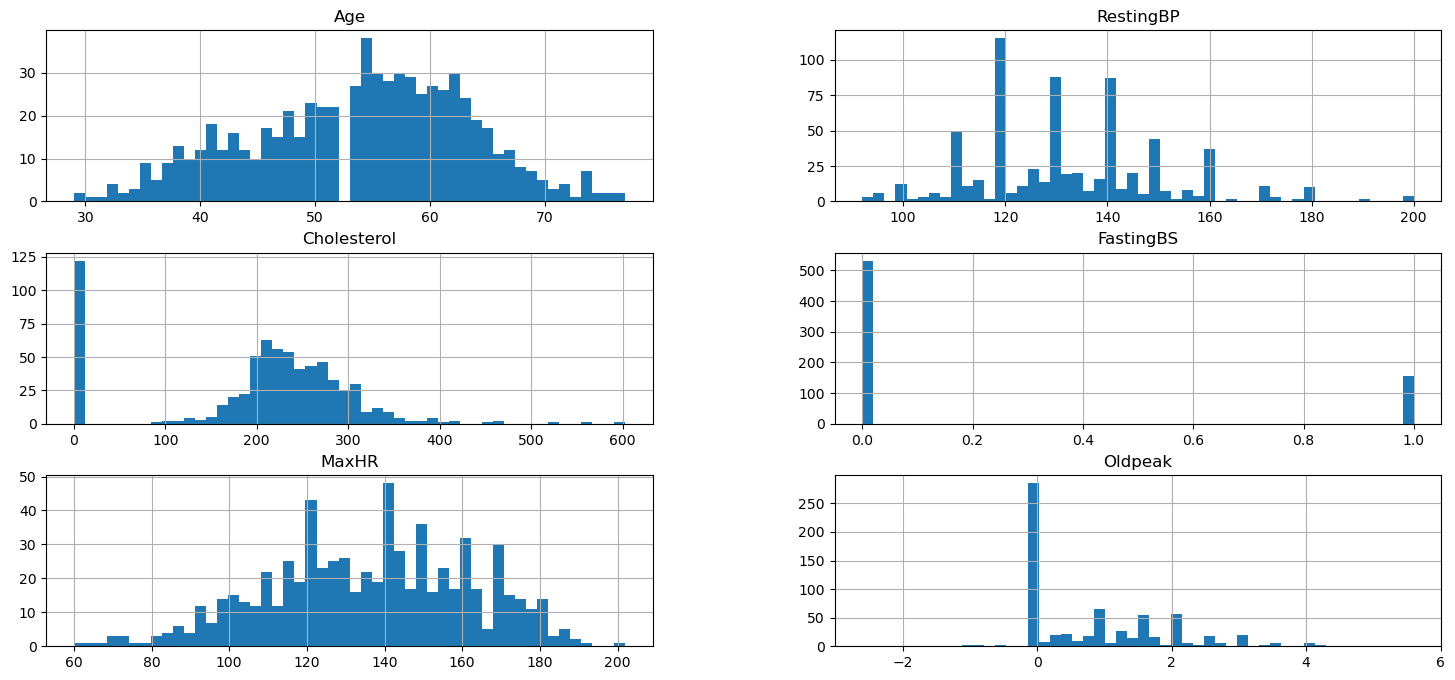

In [392]:
num_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
full_train[num_columns].hist(bins=50, figsize=(18,8))

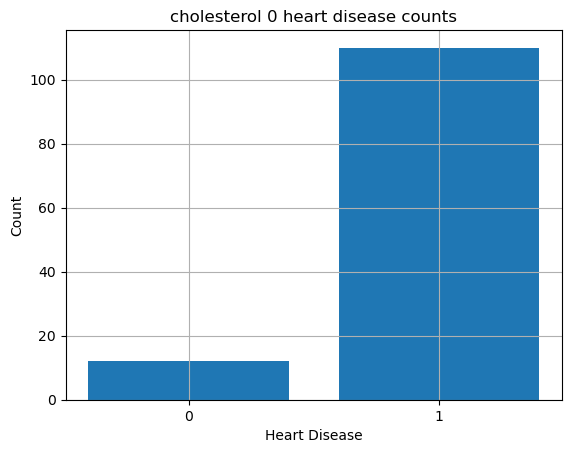

In [393]:
# Noticed that there are 122 row where cholesterol is 0
cholesterol_0_idx = full_train.index[full_train["Cholesterol"] == 0]

cholesterol_0 = full_train[full_train["Cholesterol"] == 0].copy()

# Looks like these cholesterol_0 examples are mostly heart disease related
plt.hist(x=cholesterol_0["HeartDisease"], bins=[-0.5, 0.5, 1.5], rwidth=0.8)
plt.xticks([0, 1])
plt.title("cholesterol 0 heart disease counts")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.grid()
plt.show()


cholesterol_0:  0


<Axes: >

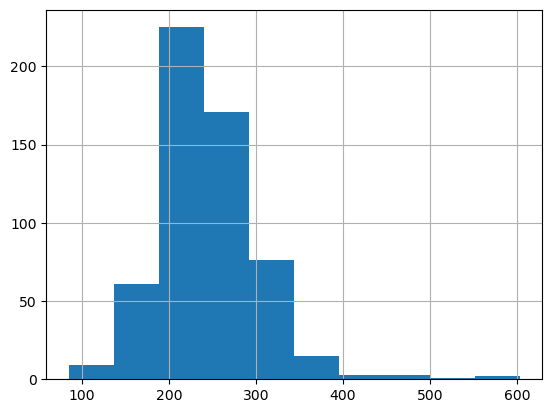

In [394]:
# Set all cholesterol 0 to None so that they get imputed later
full_train["Cholesterol"] = full_train["Cholesterol"].replace(0, np.nan)

# Confirm no more 0 cholesterol
cholesterol_0 = full_train[full_train["Cholesterol"] == 0]
print ("cholesterol_0: ", len(cholesterol_0))

# Check cholesterol distribution
full_train["Cholesterol"].hist()

In [395]:
# Store the indices of cholesterol na rows for checking after imputation

cholesterol_0_idx = full_train.index[full_train["Cholesterol"].isna()]

#### Categorical columns analysis

In [396]:
cat_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
for col in full_train[cat_columns]:
  print (f"{full_train[col].value_counts()} \n")


Sex
M    542
F    146
Name: count, dtype: int64 

ChestPainType
ASY    380
NAP    143
ATA    128
TA      37
Name: count, dtype: int64 

RestingECG
Normal    422
LVH       135
ST        131
Name: count, dtype: int64 

ExerciseAngina
N    409
Y    279
Name: count, dtype: int64 

ST_Slope
Flat    349
Up      292
Down     47
Name: count, dtype: int64 



# Data transformations
* Since we'll be using tree based models, one-hot encoding is not necessary.
* Only transformation is labeling the categorical features (also handling outliers but this data set doesn't have any).
* Although the data does not contain any missing values, we'll add an imputer to our pipeline in case inference examples
  will have missing data.

In [397]:
# Separate the full train again to data and labels

X_train = full_train.drop("HeartDisease", axis=1)
y_train = full_train["HeartDisease"].copy()

In [398]:
# Build a data transformation pipeline

def apply_label_encoding(X: DataFrame):
  transformed_df = DataFrame()
  for column_num in range(X.shape[1]):
      column = X[:, column_num]
      transformed_df[column_num] = LabelEncoder().fit_transform(column)

  return transformed_df

cat_pipeline = Pipeline([
  ("most_frequent", SimpleImputer(strategy="most_frequent")),
  ("label_encoder", FunctionTransformer(apply_label_encoding, feature_names_out="one-to-one"))
])

num_pipeline = Pipeline([
  ("impute", KNNImputer(n_neighbors=5)),
  ("standardize", RobustScaler())
])

num_columns = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
cat_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

preprocessing = ColumnTransformer([
  ("num", num_pipeline, num_columns),
  ("cat", cat_pipeline, cat_columns)
])

X_train_transformed = preprocessing.fit_transform(X_train)

X_train_transformed_df = DataFrame(X_train_transformed, 
                        columns=preprocessing.get_feature_names_out(),
                        index=X_train.index)

X_train_transformed_df.head()

,num__Age,num__RestingBP,num__Cholesterol,num__FastingBS,num__MaxHR,num__Oldpeak,cat__Sex,cat__ChestPainType,cat__RestingECG,cat__ExerciseAngina,cat__ST_Slope
0,-0.923077,-0.714286,1.061224,0.0,1.131579,0.466667,1.0,0.0,1.0,0.0,1.0
1,1.615385,-1.238095,-2.040816,0.0,-0.473684,2.000000,1.0,2.0,0.0,0.0,0.0
2,0.076923,-0.095238,-0.244898,0.0,-0.500000,1.000000,1.0,0.0,2.0,1.0,0.0
3,0.538462,0.238095,-1.616327,0.0,-0.026316,-0.200000,1.0,3.0,2.0,0.0,2.0
4,0.461538,-0.476190,0.359184,0.0,0.052632,2.066667,1.0,0.0,1.0,1.0,1.0


# Model Training

In [399]:
# Helper function to do k-fold cross validation with different scoring functions

def k_fold_cross_val_all_metrics(estimator):
  acc = cross_val_score(estimator, X_train, y_train, cv=5, scoring="accuracy")
  recall = cross_val_score(estimator, X_train, y_train, cv=5, scoring="recall")
  precision = cross_val_score(estimator, X_train, y_train, cv=5, scoring="precision")
  f1 = cross_val_score(estimator, X_train, y_train, cv=5, scoring="f1")

  print ("Accuracy:  ", np.mean(acc).round(2))
  print ("Recall:    ", np.mean(recall).round(2))
  print ("Precision: ", np.mean(precision).round(2))
  print ("F1:        ", np.mean(f1).round(2))

In [400]:
#Model 1: Random Forest
forest_clf = RandomForestClassifier(n_estimators=200,criterion="entropy")
forest_pipeline = get_full_pipeline(forest_clf)
k_fold_cross_val_all_metrics(forest_pipeline)

Accuracy:   0.85
Recall:     0.88
Precision:  0.84
F1:         0.87


In [401]:
# Model 2: XGBoost 
xgboost_clf = XGBClassifier(n_estimators=200)
xgboost_pipeline = get_full_pipeline(xgboost_clf)
k_fold_cross_val_all_metrics(xgboost_pipeline)


Accuracy:   0.84
Recall:     0.85
Precision:  0.86
F1:         0.85


# Hyperparameter Tuning

In [402]:
# Randomized search

params_ditribs = {'clf__n_estimators': randint(low=5, high=100), 
                  'clf__max_depth': randint(low=10, high=200), 
                  'clf__criterion': ['gini', 'entropy', 'log_loss']}

clf_rnd = RandomForestClassifier(random_state=42)
pipeline_rnd = get_full_pipeline(clf_rnd)

scoring = 'f1'
rnd_search = RandomizedSearchCV(pipeline_rnd, param_distributions=params_ditribs, n_iter=10, cv=3,
                                scoring=scoring, random_state=42)

rnd_search.fit(X_train, y_train)

# Getting the best model and its hyperparameters
final_pipeline = rnd_search.best_estimator_
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="rank_test_score", ascending=True, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.048417,0.000366,0.005401,0.000188,gini,30,87,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",0.874525,0.848980,0.879121,0.867542,0.013259,1
5,0.035005,0.000352,0.004524,0.000103,log_loss,159,57,"{'clf__criterion': 'log_loss', 'clf__max_depth...",0.863636,0.864000,0.863469,0.863702,0.000222,2
8,0.045520,0.000536,0.005209,0.000226,gini,170,80,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.865900,0.844262,0.879121,0.863095,0.014369,3
0,0.061028,0.000776,0.006120,0.000310,log_loss,189,97,"{'clf__criterion': 'log_loss', 'clf__max_depth...",0.866920,0.858300,0.863469,0.862896,0.003543,4
9,0.054119,0.000545,0.005469,0.000054,entropy,31,93,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.866920,0.858300,0.862454,0.862558,0.003520,5


In [403]:
# Feature importance for selected model

preprocessing = final_pipeline["preprocessing"]
clf = final_pipeline["clf"]
clf.feature_importances_
preprocessing.get_feature_names_out()

features_with_importance = list(zip(preprocessing.get_feature_names_out(), clf.feature_importances_))
features_with_importance = sorted(features_with_importance, key=lambda tup: tup[1], reverse=True)
features_with_importance

[('cat__ST_Slope', 0.24384517732169825),
 ('cat__ChestPainType', 0.14572770230615228),
 ('num__MaxHR', 0.12471154589681213),
 ('num__Oldpeak', 0.09791425978628998),
 ('num__Cholesterol', 0.08245387918431359),
 ('num__Age', 0.07939704863858363),
 ('cat__ExerciseAngina', 0.06945334227955184),
 ('num__RestingBP', 0.06851253047155162),
 ('cat__Sex', 0.03285416265741221),
 ('num__FastingBS', 0.03032518353843908),
 ('cat__RestingECG', 0.024805167919195386)]

In [404]:
# Getting prediction by threshold

clf = final_pipeline["clf"]
final_pipeline.predict_proba(X_train) # prob: [FALSE, TRUE]


array([[0.64367816, 0.35632184],
       [0.17241379, 0.82758621],
       [0.02298851, 0.97701149],
       ...,
       [0.04597701, 0.95402299],
       [0.08045977, 0.91954023],
       [0.96551724, 0.03448276]])

In [405]:
# Final evaluation on the test set
predictions_test = final_pipeline.predict(X_test)

print ("Accuracy:   ", accuracy_score(y_test, predictions_test))
print ("Precision:  ", precision_score(y_test, predictions_test))
print ("Recall:     ", recall_score(y_test, predictions_test))
print ("F1:         ", f1_score(y_test, predictions_test))

Accuracy:    0.9043478260869565
Precision:   0.9069767441860465
Recall:      0.9212598425196851
F1:          0.9140625


In [406]:
# Pickling the model
joblib.dump(final_pipeline, "heart_disease_model.pkl")

['heart_disease_model.pkl']